Notebook Color Scheme:


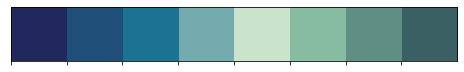

In [78]:
# Libraries
import os
import sys
#import wandb
import time
import random
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html
import imagesize
#from sklearn.model_selection import StratifiedKFold
import albumentations
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from numpy import dot, sqrt
from scipy import spatial
import cv2


# Environment check
warnings.filterwarnings("ignore")

# Custom colors
class clr:
    S = '\033[1m' + '\033[96m'
    E = '\033[0m'
    
my_colors = ["#21295C", "#1F4E78", "#1C7293", "#73ABAF", "#C9E4CA", "#87BBA2", "#618E83", "#3B6064"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))

In [68]:
# Import the training data
train = pd.read_csv("train_minus_holdout.csv")


# --- Inspect ---
print(clr.S+"--- TEST ---"+clr.E)
print(clr.S+"Total Number of Samples:"+clr.E, len(os.listdir("./test")), "\n")
print(clr.S+"--- TRAIN ---"+clr.E)
print(clr.S+"Number of Missing Values:"+clr.E, train.isna().sum().sum())
print(clr.S+"Data Shape:"+clr.E, train.shape)
train.head()

--- TEST ---
Total Number of Samples: 27956 

--- TRAIN ---
Number of Missing Values: 0
Data Shape: (49834, 5)


,image,species,individual_id,class,path
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,./train/00021adfb725ed.jpg
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,./train/000562241d384d.jpg
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,./train/0007c33415ce37.jpg
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,dolphin,./train/0007d9bca26a99.jpg
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,whale,./train/00087baf5cef7a.jpg


In [69]:
train['class'].value_counts()

whale      33205
dolphin    16629
Name: class, dtype: int64

In [70]:
train['species'].value_counts()


bottlenose_dolphin           10595
beluga_whale                  7266
humpback_whale                7205
blue_whale                    4671
false_killer_whale            3267
dusky_dolphin                 3057
killer_whale                  2394
melon_headed_whale            1653
spinner_dolphin               1639
minke_whale                   1592
fin_whale                     1287
gray_whale                    1094
southern_right_whale           840
short_finned_pilot_whale       727
spotted_dolphin                478
sei_whale                      418
common_dolphin                 335
cuviers_beaked_whale           334
long_finned_pilot_whale        230
white_sided_dolphin            224
brydes_whale                   152
pantropic_spotted_dolphin      144
commersons_dolphin              87
pygmy_killer_whale              75
rough_toothed_dolphin           57
frasiers_dolphin                13
Name: species, dtype: int64

In [72]:
train['individual_id'].value_counts()

37c7aba965a5    399
114207cab555    167
a6e325d8e924    154
19fbb960f07d    153
c995c043c353    152
               ... 
1532bab3c2b7      1
bc5452139ad9      1
565dcf1cbb01      1
a13fda84d3b1      1
bc6fcab946c4      1
Name: individual_id, Length: 15329, dtype: int64

<AxesSubplot:ylabel='Density'>

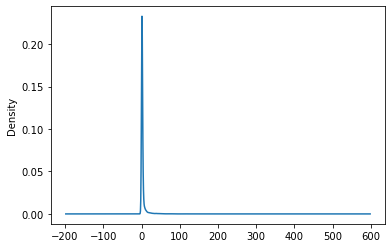

In [74]:
train['individual_id'].value_counts().plot(kind='density')

In [75]:
train.groupby(['species', 'individual_id']).size().unstack(fill_value=0)

individual_id,0013f1f5f2f0,001618e0a31e,0018a0f40586,00191b9a2f6f,001a09e48b2d,001b30a25638,0022256f1506,002371f1ff68,0024d6489e2f,002a24f8887c,...,ffd169aa30cc,ffd38c0d37ad,ffd3e5bda0ba,ffdc67cee9b4,ffe70857f5b5,fff35b58c591,fff591b41cce,fffb11ff4575,fffe15363b92,ffff6255f559
species,,,,,,,,,,,,,,,,,,,,,
beluga_whale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
blue_whale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bottlenose_dolphin,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
brydes_whale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
commersons_dolphin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
common_dolphin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cuviers_beaked_whale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dusky_dolphin,1,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
false_killer_whale,0,0,0,0,0,0,0,0,0,0,...,0,31,0,0,0,0,0,0,0,0


In [41]:
# Create a unique id column based on image name
train["image_code"] = train["image"].apply(lambda x: x.split(".")[0])

# Create a 'target' column
# Target here is just the other images from the same individual
tmp = train.groupby('individual_id')['image_code'].agg('unique').to_dict()
train['target'] = train['individual_id'].map(tmp)

# Map the individual id to a unique key (integer, not string)
individual_mapping = train["individual_id"].value_counts().reset_index().drop(columns=["individual_id"])
individual_mapping.columns = ["individual_id"]
individual_mapping["individual_key"] = np.arange(start=0, stop=len(individual_mapping), step=1)

train = pd.merge(train, individual_mapping, on="individual_id")


# Map the image_code to a unique key (integer, not string)
individual_mapping = train["image_code"].value_counts().reset_index().drop(columns=["image_code"])
individual_mapping.columns = ["image_code"]
individual_mapping["image_key"] = np.arange(start=0, stop=len(individual_mapping), step=1)

train = pd.merge(train, individual_mapping, on="image_code")




# Add Validation Fold
### based on individual key group
# skf = StratifiedKFold(n_splits=5)
# skf_splits = skf.split(X=train.drop(columns="individual_key"), y=train["individual_key"])

# for fold, (train_index, valid_index) in enumerate(skf_splits):
#       train.loc[valid_index , "kfold"] = np.int(fold)
        
# train["kfold"] = train["kfold"].astype(int)
        
# The adjusted training data
train.head(5)

,image,species,individual_id,class,path,image_code,target,individual_key,image_key
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,./train/00021adfb725ed.jpg,00021adfb725ed,[00021adfb725ed],10333,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,./train/000562241d384d.jpg,000562241d384d,"[000562241d384d, ffae18d2939ffc]",4909,12459
2,ffae18d2939ffc.jpg,humpback_whale,1a71fbb72250,whale,./train/ffae18d2939ffc.jpg,ffae18d2939ffc,"[000562241d384d, ffae18d2939ffc]",4909,33221
3,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,./train/0007c33415ce37.jpg,0007c33415ce37,"[0007c33415ce37, 07b8fac61777d6, 110c8322382c6...",70,33222
4,07b8fac61777d6.jpg,false_killer_whale,60008f293a2b,whale,./train/07b8fac61777d6.jpg,07b8fac61777d6,"[0007c33415ce37, 07b8fac61777d6, 110c8322382c6...",70,33223


In [42]:
print(len(set(train['individual_key'])))
print(len(set(train['image_key'])))

15329
49834


In [43]:


# TEST_PATH = "./test"

# test = pd.DataFrame({"image" : os.listdir(TEST_PATH)})
# test["path"] = TEST_PATH + "/" + test["image"]
# test["image_code"] = test["image"].apply(lambda x: x.split(".")[0])


# widths, heights = [], []

# for path in tqdm(test["path"]):
#     width, height = imagesize.get(path)
#     widths.append(width)
#     heights.append(height)
    
# test["width"] = widths
# test["height"] = heights
# test["dimension"] = test["width"] * test["height"]

# test.head(3)



In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(clr.S+'Device available now:'+clr.E, device)

Device available now: cuda


In [45]:
# ---- PARAMETERS ----
STATE = 24
KEYS = [0, 1, 2, 3]
IMG_SIZE = 256
BATCH_SIZE = 16
# --------------------


In [46]:
train_sample = train[train["individual_key"].isin(KEYS)].reset_index(drop=True)
train_sample["path"] = "./train/" + train_sample["image"]

train_sample.head()

,image,species,individual_id,class,path,image_code,target,individual_key,image_key
0,001001f099519f.jpg,minke_whale,19fbb960f07d,whale,./train/001001f099519f.jpg,001001f099519f,"[001001f099519f, 0164d8fd7a7cfe, 01e775c518a82...",3,32813
1,0164d8fd7a7cfe.jpg,minke_whale,19fbb960f07d,whale,./train/0164d8fd7a7cfe.jpg,0164d8fd7a7cfe,"[001001f099519f, 0164d8fd7a7cfe, 01e775c518a82...",3,32814
2,01e775c518a824.jpg,minke_whale,19fbb960f07d,whale,./train/01e775c518a824.jpg,01e775c518a824,"[001001f099519f, 0164d8fd7a7cfe, 01e775c518a82...",3,32815
3,02278d7a7d207e.jpg,minke_whale,19fbb960f07d,whale,./train/02278d7a7d207e.jpg,02278d7a7d207e,"[001001f099519f, 0164d8fd7a7cfe, 01e775c518a82...",3,32816
4,02d21d4df0b87f.jpg,minke_whale,19fbb960f07d,whale,./train/02d21d4df0b87f.jpg,02d21d4df0b87f,"[001001f099519f, 0164d8fd7a7cfe, 01e775c518a82...",3,32817


In [47]:
def get_transforms(img_size=256):
    '''Function to apply albumentations to the image.
    Keeping it simple for now - Just a resizing and normalization.'''
    
    return  albumentations.Compose([
                albumentations.Resize(img_size, img_size),
                albumentations.Normalize()
            ])

class DatasetClass(Dataset):
    def __init__(self, csv, transforms=get_transforms(img_size=256)):

        self.csv = csv
        self.transform = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        image = cv2.imread(row.path)
        image = image[:, :, ::-1]

        transformed_img = self.transform(image=image)
        transformed_img = transformed_img['image'].astype(np.float32)
        image = transformed_img.transpose(2, 0,  1)
        individual_key = torch.tensor(row.individual_key)
        image_key = torch.tensor(row.image_key)

        return torch.tensor(image), individual_key, image_key
    

# Get the data loader
#dataset = DatasetClass(train_sample, transforms=get_transforms(img_size=IMG_SIZE))
dataset = DatasetClass(train, transforms=get_transforms(img_size=IMG_SIZE))
loader = DataLoader(dataset, batch_size=BATCH_SIZE)


In [48]:
dataset.__getitem__(0)

(tensor([[[-0.6452, -0.6452, -0.6452,  ..., -0.9705, -0.9705, -0.8849],
          [-0.4054, -0.4054, -0.4054,  ..., -1.2103, -1.2103, -1.1247],
          [-0.4739, -0.4739, -0.4739,  ..., -1.1418, -1.1418, -1.0562],
          ...,
          [-1.3815, -1.3815, -1.3815,  ..., -1.2959, -1.2959, -1.2959],
          [-1.3815, -1.3815, -1.3815,  ..., -1.2959, -1.2959, -1.2959],
          [-1.3815, -1.3815, -1.3815,  ..., -1.2959, -1.2959, -1.2959]],
 
         [[ 0.0476,  0.0476,  0.0476,  ..., -0.2500, -0.2675, -0.1975],
          [ 0.2927,  0.2927,  0.2927,  ..., -0.4951, -0.5126, -0.4426],
          [ 0.2227,  0.2227,  0.2227,  ..., -0.4251, -0.4426, -0.3725],
          ...,
          [-1.3179, -1.3179, -1.3179,  ..., -1.2304, -1.2304, -1.2304],
          [-1.3179, -1.3179, -1.3179,  ..., -1.2304, -1.2304, -1.2304],
          [-1.3179, -1.3179, -1.3179,  ..., -1.2304, -1.2304, -1.2304]],
 
         [[ 1.1934,  1.1934,  1.1934,  ...,  0.7054,  0.7228,  0.9494],
          [ 1.4374,  1.4374,

In [49]:
class BackboneModel(nn.Module):
    def __init__(self):
        super(BackboneModel, self).__init__()
        # Retrieve pretrained weights
        self.backbone = EfficientNet.from_pretrained('efficientnet-b7')
        
    def forward(self, img):            
        img = self.backbone(img)
        return img
    
# Initiate the model
model = BackboneModel().to(device)

Loaded pretrained weights for efficientnet-b7


In [50]:
torch.no_grad()

# Barebone example of the image embedding and cosine code

In [51]:
image_black = cv2.imread('black.png')
image_black = image_black[:, :, ::-1]
image_black = image_black.astype(np.float32)
image_black = image_black.transpose(2, 0,  1)
print(image_black.shape)

image_blackwhite = cv2.imread('whiteblack.png')
image_blackwhite = image_blackwhite[:, :, ::-1]
image_blackwhite = image_blackwhite.astype(np.float32)
image_blackwhite = image_blackwhite.transpose(2, 0,  1)
print(image_blackwhite.shape)

(3, 300, 598)
(3, 300, 598)


In [52]:
image_black = torch.tensor(image_black)
image_black = image_black[None, :]
print(image_black.shape)

image_blackwhite = torch.tensor(image_blackwhite)
image_blackwhite = image_blackwhite[None, :]
print(image_blackwhite.shape)

torch.Size([1, 3, 300, 598])
torch.Size([1, 3, 300, 598])


In [53]:
image_black = image_black.to(device)
image_black_embedding = model(image_black)
image_black_embedding = image_black_embedding.detach().cpu().numpy()

image_blackwhite = image_blackwhite.to(device)
image_blackwhite_embedding = model(image_blackwhite)
image_blackwhite_embedding = image_blackwhite_embedding.detach().cpu().numpy()

In [54]:
spatial.distance.cosine(image_black_embedding, image_black_embedding)

0.0

In [55]:
spatial.distance.cosine(image_black_embedding, image_blackwhite_embedding)

0.596339613199234

In [56]:
spatial.distance.euclidean(image_black_embedding, image_black_embedding)

0.0

In [57]:
spatial.distance.euclidean(image_black_embedding, image_blackwhite_embedding)

6.538520812988281

# Create the embeddings

#### The embeddings are already created and included, but you can retrain here if you want

In [20]:
retrain=False

if retrain:

    # Retrieve all embeddings for each image
    image_embeddings = []
    individual_keys = []
    image_keys = []

    with torch.no_grad():
        for img, individual_key, image_key in tqdm(loader): 
            img = img.to(device)
            img_embedding = model(img)
            img_embedding = img_embedding.detach().cpu().numpy()
            image_embeddings.append(img_embedding)
            individual_keys.append(individual_key.numpy())
            image_keys.append(image_key.numpy())


#### Check what we created

In [21]:
if retrain:
    # Concatenate batches together
    image_embeddings = np.concatenate(image_embeddings)
    individual_keys = np.concatenate(individual_keys)
    image_keys = np.concatenate(image_keys)


In [22]:
if retrain:
    image_embeddings[0]

In [23]:
if retrain:
    individual_keys[0]

In [24]:
if retrain:
    image_keys[0]

In [25]:
if retrain:
    # Save embeddings and corresponding image
    np.save('effnet_image_embeddings.npy', image_embeddings)
    np.save('effnet_individual_keys.npy', individual_keys)
    np.save('effnet_image_keys.npy', image_keys)

# Load the embeddings

In [26]:
import numpy as np
image_embeddings = np.load('effnet_image_embeddings.npy')
individual_keys = np.load('effnet_individual_keys.npy')
image_keys = np.load('effnet_image_keys.npy')

In [27]:
def get_cosine_similarity(embeddings):
    '''Compute cos distance between n embedding vector and itself.'''
    similarity_matrix = []
    
    for embed1 in embeddings:
        similarity_row = []
        for embed2 in embeddings:
            similarity_row.append(spatial.distance.cosine(embed1, embed2))
        similarity_matrix.append(similarity_row)
    
    return np.array(similarity_matrix, dtype="float32")


#### Example cosine similarity of two images

In [28]:
cos_matrix = get_cosine_similarity([image_embeddings[0],image_embeddings[1]])
cos_matrix

array([[0.       , 1.1578689],
       [1.1578689, 0.       ]], dtype=float32)

#### Example cosine similarity of the images of an individual

In [29]:
# Select few examples from the same individual
example_index = train_sample[train_sample["individual_key"]==1].sample(5, random_state=24).index.tolist()
print(f"Example index: {example_index}")
example_paths = train_sample[train_sample["individual_key"]==1].sample(5, random_state=24)["path"].tolist()
example_embeds = image_embeddings[example_index]

# Compute similarity matrix
cos_matrix = get_cosine_similarity(example_embeds)

mask = np.zeros_like(cos_matrix)
mask[np.triu_indices_from(mask)] = True


Example index: [308, 277, 167, 251, 217]


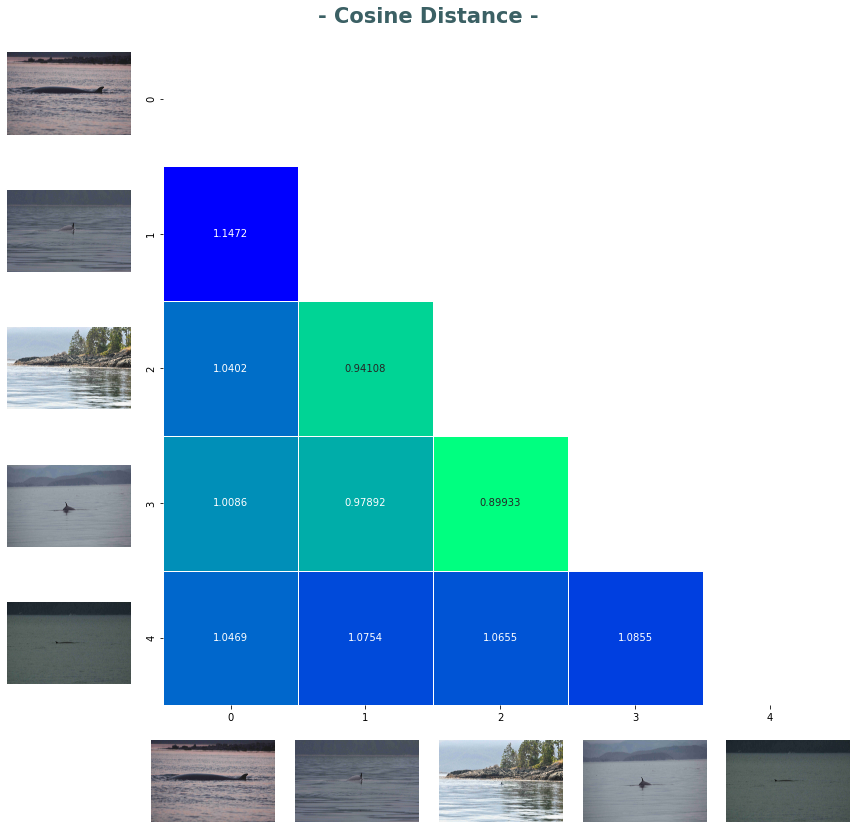

In [30]:
# Plots
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid(shape=(6, 6), loc=(5, 1), colspan=1)
ax2 = plt.subplot2grid(shape=(6, 6), loc=(5, 2), colspan=1)
ax3 = plt.subplot2grid(shape=(6, 6), loc=(5, 3), colspan=1)
ax4 = plt.subplot2grid(shape=(6, 6), loc=(5, 4), colspan=1)
ax5 = plt.subplot2grid(shape=(6, 6), loc=(5, 5), colspan=1)
h_axes = [ax1, ax2, ax3, ax4, ax5]

ax6 = plt.subplot2grid(shape=(6, 6), loc=(0, 0), colspan=1)
ax7 = plt.subplot2grid(shape=(6, 6), loc=(1, 0), colspan=1)
ax8 = plt.subplot2grid(shape=(6, 6), loc=(2, 0), colspan=1)
ax9 = plt.subplot2grid(shape=(6, 6), loc=(3, 0), colspan=1)
ax10 = plt.subplot2grid(shape=(6, 6), loc=(4, 0), colspan=1)
v_axes = [ax6, ax7, ax8, ax9, ax10]

ax11 = plt.subplot2grid(shape=(6, 6), loc=(0, 1), colspan=5, rowspan=5)

fig.suptitle('- Cosine Distance -', size = 21, color = my_colors[7], weight='bold')
for k, ax in enumerate(h_axes):
    ax.imshow(plt.imread(example_paths[k]))
    ax.set_axis_off()
    
for k, ax in enumerate(v_axes):
    ax.imshow(plt.imread(example_paths[k]))
    ax.set_axis_off()
    
sns.heatmap(cos_matrix, ax=ax11, fmt=".5",
            cbar=False, annot=True, linewidths=0.5, mask=mask, square=True, cmap="winter_r")

plt.tight_layout()
plt.show();

# The example of final output:

In [31]:
holdout=pd.read_csv('holdout_y.csv')
holdout.head()

,image
0,57cae124515b2d.jpg
1,094d2dfb60370f.jpg
2,40c97c14da3308.jpg
3,ea79e90cf8e8c4.jpg
4,1f430013db7d8b.jpg


In [32]:
def dummy_function(image):
    return random.sample(train['individual_id'].to_list(), 5)

In [33]:
pred_list = []
for _, row in holdout.iterrows():
    pred_list.append(dummy_function(row['image']))

In [34]:
holdout['predictions'] = pred_list

In [35]:
holdout.head()

,image,predictions
0,57cae124515b2d.jpg,"[6a31b9b3cfa3, 174eee0d4405, 9a6b86f7bb3e, 7d0..."
1,094d2dfb60370f.jpg,"[7bdf83ff6076, 542f5be1b35c, 22c1eb2c8af4, 845..."
2,40c97c14da3308.jpg,"[c2705f9e75c8, 2b8bcbb8aa60, ef0ddd083fbe, 057..."
3,ea79e90cf8e8c4.jpg,"[394e6fdcb870, 9b9b407da324, 89e3af85784c, 0a9..."
4,1f430013db7d8b.jpg,"[f132db28cd92, 6d1cc6d00dca, fe61bb288491, 1dd..."


In [36]:
holdout.to_csv('final_predictions.csv', index=False)